In [1]:
# #Imports
# #Dataprep
# import matplotlib.pyplot as plt
# import numpy as np
# from nilearn import datasets, plotting, image
# from nilearn.maskers import NiftiMapsMasker
# from sklearn.decomposition import FastICA
# import pandas as pd
# import tarfile
# import gzip
# #sim required
# import random
# import pingouin as pg
# import seaborn as sns
# #GNN required
# import torch
# import torch.nn.functional as F
# from torch.nn import Linear
# import torch.nn as nn
# import torch_geometric
# from torch_geometric.nn import GCNConv
# from torch_geometric.nn import SAGEConv
# from torch_geometric.nn import GraphConv
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader
# from torch.utils.data import SubsetRandomSampler
# from sklearn.metrics import accuracy_score

# STEP 1. Input Data Selection

**Deliverables:**  
**Goal**: Create different sub-graphs two decrease training times and aid in overall interpretability of GNN performance

**Sub-graph Types**
1. Significant Regions [alpha] 
2. Significant Regions [bonferroni-corrected] 
3. Graph Sampling [GRAPHSaint]

In [2]:
# imports for this section
from ast import literal_eval
import re
import gzip
import pandas as pd
import numpy as np
import torch

C:\Users\Jense\AppData\Local\Temp\ipykernel_8820\2238771519.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## I. Read in the HCP data

In [3]:
data_file = 'Data/data_clean.csv.gz'

with gzip.open(data_file) as filepath:
    data = pd.read_csv(filepath, index_col = 'subject_id', 
            converters = {'netmat' : lambda x : np.array(literal_eval(re.sub('(?<!\[)\s+|[\\n]', ', ', x)))})
    
data.head()

,Gender,Age,netmat
subject_id,,,
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."


## II. Get the input subgraphs

In [4]:
# STEP 1: INPUT DATA TYPES
# -> FILTERING
# 1. Sig Regions [alpha] 
# 2. Sig Regions [bonferroni-corrected] 
# 3. Graph Sampling [GRAPHSaint]

In [5]:
%%time
# full dataset
graphs = np.stack(data.netmat.to_numpy()) # all 1003 correlation matrices
edges = np.argwhere(graphs)
# significant edges
edges_sig = np.triu(np.genfromtxt('significant_edges.csv', delimiter=',')) # only keep unique edges
graphs_sig = np.where(edges_sig, graphs, 0) # only keep significant correlations
# bonferroni significant edges
edges_sig_b = np.triu(np.genfromtxt('bonferroni_sig_edges.csv', delimiter=',')) # only keep unique edges
graphs_sig_b = np.where(edges_sig, graphs, 0)# only keep significant correlations

CPU times: total: 281 ms
Wall time: 276 ms


In [6]:
# get edges into correct format for later
edges_sig = torch.tensor(np.argwhere(edges_sig).T)
edges_sig_b = torch.tensor(np.argwhere(edges_sig_b).T)

In [7]:
# labels
data['Gender'] = data['Gender'].replace({"M":0, "F":1})
labels = torch.tensor(data['Gender'].values)

C:\Users\Jense\AppData\Local\Temp\ipykernel_8820\1997748793.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'] = data['Gender'].replace({"M":0, "F":1})


In [8]:
labels

tensor([0, 1, 0,  ..., 1, 0, 1])

## III. Train-Validate-Test split

In [9]:
# imports for this section
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import accuracy_score

In [10]:
def collate(data_list):
    """
    Unpacks graphs and their corresponding labels from a list of tuples.

    Parameters:
    - data_list (list of tuples): A list where each tuple contains a graph and its corresponding label.

    Returns:
    A dictionary with the following keys:
    - 'graph' (list): A list containing all the graphs extracted from the tuples.
    - 'label' (list): A list containing all the labels extracted from the tuples.
    """
    graphs, labels = map(list, zip(*data_list))
    return {
        'graph': graphs,
        'label': labels
    }
 

In [11]:
class CorrelationDataset(torch.utils.data.Dataset):
    def __init__(self, netmats, edges, labels, split_ratio=(0.8, 0.1, 0.1)):
        """
        Initializes the dataset with pairwise correlation matrices, labels, and edges.
    
        Parameters:
        - netmats (array-like): Pairwise correlation matrices.
        - edges (array-like): Regions that make up each pairwise correlation from `netmats`.
        - labels (array-like): Labels indicating gender (0 for male, 1 for female).
        - split_ratio (tuple): Ratios for splitting the data into train, validation, and test sets. Default is (0.8, 0.1, 0.1).
    
        Splits the data into training, validation, and test sets based on the specified split ratios.
        """
        self.netmats = netmats # pairwise correlation matrix
        self.labels = labels # female (1) or male (0)
        self.edges = edges # regions that make up each pairwise correlation from `netmats`
        self.split_ratios = split_ratio
        tot = len(self.netmats)
        train_samples = int(split_ratio[0] * tot) # 0.8
        val_samples = int(split_ratio[1] * tot) # 0.1

        # splitting the data
        self.train_indices = np.arange(0, train_samples) # training data
        self.val_indices = np.arange(train_samples, train_samples + val_samples) # validation data
        self.test_indices = np.arange(train_samples + val_samples, tot) # test data

    def __len__(self):
        """
        Returns the length of entire dataset (train + validate + test)
        """
        return len(self.netmats)

    def __getitem__(self, idx):
        """
        Retrieves the data and label corresponding to the given index.
    
        Parameters:
        - idx (int): Index of the data sample to retrieve.
    
        Returns:
        - graph_data (torch_geometric.data.Data): Graph data containing the correlation matrix and edge indices.
        - label (int): Label indicating the gender (0 for male, 1 for female) of the corresponding data sample.
        """
        x = torch.tensor(self.netmats[idx]).float() # correlation matrix
        edge_index = self.edges # dependent on input subgraph
        graph_data = Data(x=x, edge_index=edge_index) 
        label = self.labels[idx]
        return graph_data, label

    def get_split(self, idx):
        """
        Determines the split of a data sample based on its index.
    
        Parameters:
        - idx (int): Index of the data sample.
    
        Returns:
        - split (str): The split of the data sample ('train', 'val', or 'test').
    
        Raises:
        - ValueError: If the index is not found in any of the splits.
        """
        if idx in self.train_indices:
            return 'train'
        elif idx in self.val_indices:
            return 'val'
        elif idx in self.test_indices:
            return 'test'
        else:
            raise ValueError('Index not in any split')

In [12]:
def create_dataset(netmats, edges, labels=labels, collate_fn=collate):
    """
    Creates a dataset and corresponding data loaders for training, validation, and testing.

    Parameters:
    - netmats (array-like): Pairwise correlation matrices.
    - edges (array-like): Regions that make up each pairwise correlation from `netmats`.
    - labels (array-like): Labels indicating gender (0 for male, 1 for female).
    - collate_fn (function, optional): Function to collate data samples into batches. Default is `collate`.

    Returns:
    A dictionary containing the following keys:
    - 'dataset' (CorrelationDataset): The created dataset.
    - 'train_loader' (torch.utils.data.DataLoader): DataLoader for training data.
    - 'validate_loader' (torch.utils.data.DataLoader): DataLoader for validation data.
    - 'test_loader' (torch.utils.data.DataLoader): DataLoader for test data.
    """
    dataset = CorrelationDataset(netmats, edges, labels, split_ratio=(0.8, 0.1, 0.1))
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)
    return {
        'dataset': dataset,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader
    }

In [13]:
%%time
# train-validate-test splits
# full dataset
# full =  create_dataset(graphs, edges.T)
# significant pairwise correlations only
sig = create_dataset(graphs, edges_sig)
# bonferroni significant pairwise correlations only
# sig_b = create_dataset(graphs, np.argwhere(edges_sig_b).T)

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
foo = iter(sig['train_loader'])
next(foo)

{'graph': [Data(x=[100, 100], edge_index=[2, 1695])], 'label': [tensor(1)]}

# STEP 2. Model Development

In [24]:
# new imports for this section
import matplotlib.pyplot as plt

In [172]:
def train(model, data_loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_true = 0
    num_true_guesses = 0
    for d in data_loader:
        m = d['graph'][0]
        m = m.to(device)
        label = d['label'][0]
        optimizer.zero_grad()
        out = model(d).squeeze()
        loss = loss_fn(out.float(), label.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = (out.double() > 0.5).float()
        if pred == label.double():
            num_true += 1
        if pred == 1:
            num_true_guesses += 1
    return total_loss, num_true, num_true_guesses

def eval(model, loader, device):
    model.eval()
    cor = 0
    tot = 0
    for d in loader:
        with torch.no_grad():
            out = model(d)
            pred = (out.double() > 0.5).float()
        y = d['label'][0]
        cor += (pred == y).sum()
        tot += pred.shape[0]
    return cor/tot

def train_validate_model(model, optimizer, criterion, dataset):
    train_data = 'train_loader'
    val_data = 'val_loader'
    test_data = 'test_loader'

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    losses = []
    num_epochs = 50
    for epoch in range(num_epochs):
        loss, num_true, num_true_guesses = train(model, dataset[train_data], device, criterion, optimizer)
        train_results = eval(model, dataset[train_data], device)
        val_results = eval(model, dataset[val_data], device)
        losses.append(loss)
        avg_loss = loss / len(sig[train_data])
        print(f'Epoch: {epoch + 1}/{num_epochs}, '
              f'Loss: {loss}, '
              f'Avg Loss: {avg_loss:.3f}, '
              f'Train: {100 * train_results:.2f}%, '
              f'Validation: {100 * val_results:.2f}%, '
              f'Num Correct: {num_true}, '
              f'True Guesses: {num_true_guesses} ')
    plt.plot(losses)
    plt.show() 
    return avg_loss

In [177]:
class GCN(nn.Module):
    def __init__(self,):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(100, 150)
        self.bn1 = nn.BatchNorm1d(150)
        self.conv2 = GCNConv(150, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.classifier = Linear(50, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.classifier(x).mean(dim=0)
        x = torch.sigmoid(x)
        return x
    
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(100, 150)
  (bn1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(150, 50)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)


Epoch: 1/50, Loss: 553.9281856715679, Avg Loss: 0.691, Train: 46.76%, Validation: 51.00%, Num Correct: 428, True Guesses: 626 
Epoch: 2/50, Loss: 551.9193088114262, Avg Loss: 0.688, Train: 51.87%, Validation: 46.00%, Num Correct: 425, True Guesses: 531 
Epoch: 3/50, Loss: 554.5436206459999, Avg Loss: 0.691, Train: 45.26%, Validation: 51.00%, Num Correct: 421, True Guesses: 735 
Epoch: 4/50, Loss: 547.5814880430698, Avg Loss: 0.683, Train: 42.14%, Validation: 47.00%, Num Correct: 444, True Guesses: 568 
Epoch: 5/50, Loss: 537.8227994143963, Avg Loss: 0.671, Train: 38.28%, Validation: 42.00%, Num Correct: 467, True Guesses: 651 
Epoch: 6/50, Loss: 521.7958734929562, Avg Loss: 0.651, Train: 36.78%, Validation: 41.00%, Num Correct: 502, True Guesses: 532 
Epoch: 7/50, Loss: 482.20167081803083, Avg Loss: 0.601, Train: 35.66%, Validation: 41.00%, Num Correct: 542, True Guesses: 484 
Epoch: 8/50, Loss: 455.2750052176416, Avg Loss: 0.568, Train: 34.16%, Validation: 40.00%, Num Correct: 573, Tr

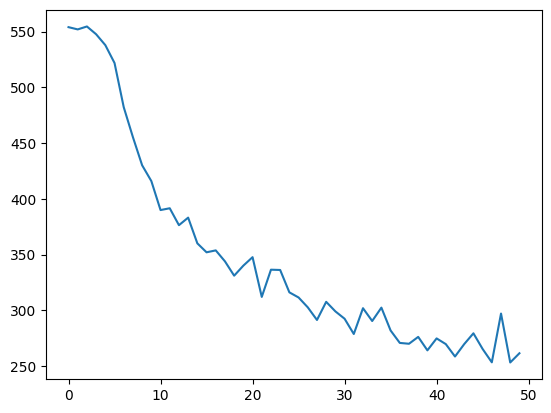

0.3261494287282784

In [179]:
train_validate_model(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=0.003), criterion=nn.BCELoss(), dataset=sig)

In [194]:
# 2-layer models

class twoGCN_custom(nn.Module):
    """
    Graph Convolutional Network (GCN) with customizable hyperparameters.

    Args:
        input_dim (int): Dimension of the input features.
        hidden_dim1 (int): Dimension of the first hidden layer.
        hidden_dim2 (int): Dimension of the second hidden layer.
        output_dim (int): Dimension of the output.
        dropout_prob (float): Dropout probability.

    Attributes:
        conv1 (GCNConv): First graph convolutional layer.
        bn1 (BatchNorm1d): Batch normalization layer for the first hidden layer.
        conv2 (GCNConv): Second graph convolutional layer.
        bn2 (BatchNorm1d): Batch normalization layer for the second hidden layer.
        classifier (Linear): Linear layer for classification.
        dropout_prob (float): Dropout probability.

    """
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout_prob):
        super(twoGCN_custom, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.classifier = Linear(hidden_dim2, 1) # output dimension will always be 1
        self.dropout_prob = dropout_prob

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=self.dropout_prob)(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=self.dropout_prob)(x)
        x = self.classifier(x).mean(dim=0)
        x = torch.sigmoid(x)
        return x

twoGCN_custom(
  (conv1): GCNConv(100, 150)
  (bn1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(150, 50)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)
Epoch: 1/50, Loss: 554.6957270503044, Avg Loss: 0.692, Train: 45.26%, Validation: 45.00%, Num Correct: 434, True Guesses: 802 
Epoch: 2/50, Loss: 553.6416662931442, Avg Loss: 0.690, Train: 46.38%, Validation: 41.00%, Num Correct: 435, True Guesses: 801 
Epoch: 3/50, Loss: 554.3143500685692, Avg Loss: 0.691, Train: 48.25%, Validation: 43.00%, Num Correct: 434, True Guesses: 802 
Epoch: 4/50, Loss: 554.8472759127617, Avg Loss: 0.692, Train: 48.75%, Validation: 46.00%, Num Correct: 433, True Guesses: 799 
Epoch: 5/50, Loss: 553.7416647076607, Avg Loss: 0.690, Train: 50.12%, Validation: 50.00%, Num Correct: 433, True Guesses: 801 
Epoch: 6/50, Loss: 553.9663127660751, Avg Loss

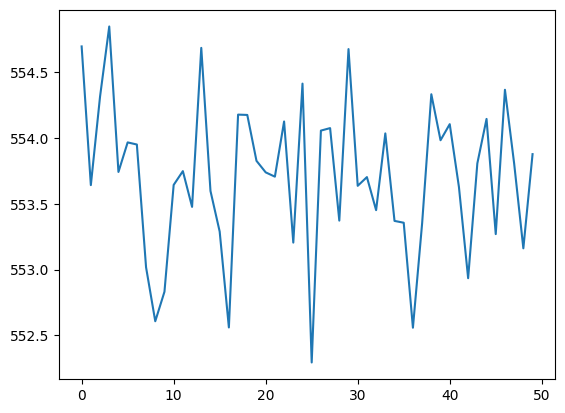

0.690619832634034

In [196]:
twoGCN_1 = twoGCN_custom(
    input_dim=100,
    hidden_dim1=150, 
    hidden_dim2=50, 
    dropout_prob=0.50,
    activation_functions=[torch.tanh, torch.tanh]
)
print(twoGCN_1)
train_validate_model(model=twoGCN_1, optimizer=torch.optim.Adam(model.parameters(), lr=0.003), criterion=nn.BCELoss(), dataset=sig)

In [ ]:
# twoGCN_1 = twoGCN_custom(
#     input_dim=100,
#     hidden_dim1=150, 
#     hidden_dim2=50, 
#     dropout_prob=0.50,
#     activation_functions=[torch.tanh, torch.tanh]
# )
# print(twoGCN_1)
# train_validate_model(model=twoGCN_1, optimizer=torch.optim.Adam(model.parameters(), lr=0.003), criterion=nn.BCELoss(), dataset=sig)

In [ ]:
# twoGCN_3 = twoGCN_custom(
#     input_dim=100, 
#     hidden_dim1=150, 
#     hidden_dim2=50, 
#     dropout_prob=0.50,
#     activation_functions=[tanh, tanh]
# )
# print(twoGCN_2)
# train_validate_model(model=twoGCN_3, optimizer=torch.optim.Adam(model.parameters(), lr=0.003), criterion=nn.BCELoss(), dataset=sig)